<a href="https://colab.research.google.com/github/jesusvc5/RL_LAVC/blob/main/Deep_Q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación, análisis y evaluación del método de Deep Q-Learning sobre el entorno Mountain Car

*Description*: En este notebook se desarrolla la implementación del método de **Deep Q-Learning**, y se emplea sobre el entorno Mountain Car de Gymnasium.


    Autores: Jesús Verdú Chacón
             Jorge López Abad

    Emails: jesus.v.c@um.es
            jorge.lopeza@um.es
            
    Date: 2025/03/09

In [1]:
%%capture
!pip install 'gym[box2d]==0.20.0'

In [2]:
import random
import gymnasium as gym
from gymnasium import ObservationWrapper
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Semillas Fijas

In [3]:
import os
import gc
import torch
import numpy as np
import gymnasium as gym

# Configuración del dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Liberación de memoria para evitar problemas de consumo en GPU
gc.collect() # Ejecuta el recolector de basura de Python
torch.cuda.empty_cache() # Vacía la caché de memoria en GPU

# Depuración de errores en CUDA
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # Muestra errores de CUDA en el punto exacto donde ocurren

# Configuración de la semilla para reproducibilidad
SEED = 2024 # Se define una semilla fija

# Fijar la semilla en NumPy
np.random.seed(SEED) # Para generar números aleatorios consistentes en NumPy
np.random.default_rng(SEED) # Establece una instancia del generador de NumPy con la misma semilla

# Fijar la semilla en Python
os.environ['PYTHONHASHSEED'] = str(SEED) # Evita variabilidad en hashing de Python

# Fijar la semilla en PyTorch
torch.manual_seed(SEED) # Asegura resultados reproducibles en operaciones de PyTorch
if torch.cuda.is_available(): # Si hay GPU disponible
  torch.cuda.manual_seed(SEED) # Fija la semilla para la GPU
  torch.backends.cudnn.deterministic = True # Hace las operaciones de CUDNN determinísticas
  torch.backends.cudnn.benchmark = False # Desactiva optimizaciones de CUDNN para evitar variabilidad


Usando dispositivo: cpu


## Red Neuronal

Otra alternativa dentro de los métodos aproximados para trabajar con el entorno de Mountain Car es el uso de redes neuronales para el cálculo de la función $Q(s,t)$. Para SARSA también existe su variante con red neuronal, pero nosotros implementaremos el caso para Q-Learning, **Deep Q-Learning**.

In [4]:
import numpy as np
import gym
from IPython.display import clear_output, display
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import copy
import time
import matplotlib.pyplot as plt

La red neuronal que definimos para obtener los pesos $w$ tiene la siguiente estructura:
* Una capa de entrada de tamaño de input la dimensión del espacio de estados (2), y de salida el tamaño de la capa oculta.
* Una capa oculta con 64 nodos ocultos, que conecta la capa de entrada con la de salida.
* Una capa de salida, con tamaño de input de 64, y de salida la dimensión del espacio de acciones del entorno (3).
* Función de activación usaremos la **RELU**.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Definición de la Red Neuronal Profunda DQN
class DQN_Network(nn.Module):
  """
  Red neuronal para el algoritmo Deep Q-Network (DQN).
  Se compone de capas totalmente conectadas (FC) con activaciones ReLU.
  """

  def __init__(self, state_dim, action_dim, hidden_dim=64):
    """
    Inicializa la red neuronal.
    Parámetros:
    num_actions (int): Número total de acciones posibles en el entorno.
    input_dim (int): Dimensión del espacio de estados de entrada.
    """

    super(DQN_Network, self).__init__()
    # Primera capa: de estado a capa oculta de tamaño hidden_dim.
    self.fc1 = nn.Linear(state_dim, hidden_dim)
    # Segunda capa oculta.
    self.fc2 = nn.Linear(hidden_dim, hidden_dim)
    # Capa de salida: de hidden_dim a número de acciones.
    self.fc3 = nn.Linear(hidden_dim, action_dim)

  def forward(self, x):
    """
    Propagación hacia adelante.

    Parámetro:
      - x (Tensor): Estado de entrada con forma [batch_size, state_dim].

    Retorna:
      - Tensor: Valores Q para cada acción, con forma [batch_size, action_dim].
    """
    # Aplicar la primera capa seguida de ReLU.
    x = F.relu(self.fc1(x))
    # Aplicar la segunda capa seguida de ReLU.
    x = F.relu(self.fc2(x))
    # Capa de salida sin activación, para obtener los valores Q.
    x = self.fc3(x)
    return x


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Replay Buffer

Para la implementación del algoritmo de Deep Q-Learning necesitamos implementar un Replay Buffer para que el método converga a la política óptima. Este buffer tendrá el tamaño que le indiquemos como hiperparámetro en la definición del agente, y almacenará tuplas del tipo: (`estado`, `acción`, `recompensa`, `siguiente estado`, `terminado`).

In [6]:
from collections import deque
import random

class ReplayBuffer:
  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)

  def push(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  # Muestreo aleatorio del buffer
  def sample(self, batch_size):
    # Extraemos batch_size indices del buffer sin reemplazo
    batch = random.sample(self.buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # Convertimos las listas a numpy arrays antes de transformarlas en tensores
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    dones = np.array(dones)

    # Convertimos los numpy arrays a tensores
    return (
        torch.from_numpy(states).float(),
        torch.from_numpy(actions).long().unsqueeze(1),
        torch.from_numpy(rewards).float().unsqueeze(1),
        torch.from_numpy(next_states).float(),
        torch.from_numpy(dones).float().unsqueeze(1),
    )

  def __len__(self):
    return len(self.buffer)


## Definición del agente

Definimos la clase del agente, el cual tendrá información sobre la estructura de la red neuronal, y el replay buffer usado.

La política de comportamiento empleada es, como viene siendo habitual, una $\epsilon$-greedy.

Sabemos que Deep Q-Learning presenta el problema de la **sobreestimación**, esto es, la política objetivo magnifica el error y conduce a políticas subóptimas. Para compensar esto, implementamos el **Aprendizaje Doble**, el cual consiste en emplea dos redes neuronales para actualizar los pesos, una **red principal** que seleccione las acciones, y una **red objetivo**, que evalúe estas acciones seleccionadas. Esto aumenta el coste computacional, al tener que estar entrenando dos redes al mismo tiempo, pero nos elimina sesgos, y nos solventa el problema de la sobreestimación.

In [7]:
import torch.optim as optim
class DQN_Agent:
  def __init__(self,
               env:gym.Env,
               hidden_dim=64,
               lr=1e-3,
               gamma=0.99,
               epsilon=1.0,
               epsilon_min=0.05,
               epsilon_decay=0.995,
               buffer_size=5000,
               batch_size=32,
               target_update_freq=1000,
               max_steps_episode=200):
    self.env = env
    self.state_dim = self.env.observation_space.shape[0]
    self.action_dim = self.env.action_space.n
    self.gamma = gamma  # Factor de descuento
    self.epsilon = epsilon  # Exploración inicial
    self.epsilon_min = epsilon_min  # Exploración mínima
    self.epsilon_decay = epsilon_decay  # Factor de decaimiento de epsilon
    self.batch_size = batch_size
    self.steps = 0
    self.target_update_freq = target_update_freq  # Frecuencia de actualización de la red target

    self.max_steps_episode = max_steps_episode

    # Red neuronal y optimizador
    self.qnet = DQN_Network(self.state_dim, self.action_dim, hidden_dim)

    # Red target para Double Q-learning
    self.qnet_target = DQN_Network(self.state_dim, self.action_dim, hidden_dim)
    # Para inicializar igual que la red principal
    self.qnet_target.load_state_dict(self.qnet.state_dict())

    self.optimizer = optim.Adam(self.qnet.parameters(), lr=lr, amsgrad=True, foreach=True) # Para introducir AMSGrad si Adam da inestabilidad debido a gradientes oscilantes
    self.loss_function = nn.MSELoss()

    # Replay Buffer
    self.replay_buffer = ReplayBuffer(buffer_size)

  # Política epsilon-greedy
  def get_action(self, state):

    if np.random.rand() < self.epsilon:
      return np.random.randint(self.action_dim)  # Exploración
    else:
      if not isinstance(state, torch.Tensor):
        state = torch.FloatTensor(state).unsqueeze(0)  # Convertir a tensor con batch
      with torch.no_grad():
        q_values = self.qnet(state)
      return torch.argmax(q_values).item()  # Acción con mayor Q(s, a)

  def greedy_action(self, state):
    if not isinstance(state, torch.Tensor):
      state = torch.FloatTensor(state).unsqueeze(0)  # Convertir a tensor con batch
    with torch.no_grad():
      q_values = self.qnet(state)
    return torch.argmax(q_values).item()  # Acción con mayor Q(s, a)

  def update(self):

    if len(self.replay_buffer) < self.batch_size:
      return  # No entrenar hasta que haya suficientes datos en el buffer

    # Muestrea batch de experiencias
    states, actions, rewards, next_states, dones = self.replay_buffer.sample(self.batch_size)

    # Obtiene Q(s, a) actual de la red principal
    q_values = self.qnet(states)
    # Selecciona Q(s, a) correcto
    qsa = torch.gather(q_values, dim=1, index=actions)

    # Usamos la red principal para seleccionar la acción en el siguiente estado
    with torch.no_grad():
      q_next_values = self.qnet(next_states)
      next_actions = torch.argmax(q_next_values, dim=1, keepdim=True)

      # Evaluamos el valor de la acción seleccionada usando la red target
      qsa_next = self.qnet_target(next_states)
      qsa_next_target = torch.gather(qsa_next, dim=1, index=next_actions)

    # Calcula el valor objetivo Q_target usando la ecuación de Bellman
    qsa_target = rewards + (1 - dones) * self.gamma * qsa_next_target

    # Calcula la pérdida
    loss = self.loss_function(qsa, qsa_target)

    if loss is None:
      print(f"Error: El valor de pérdida es None. qsa: {qsa}, qsa_target: {qsa_target}")

    # Retropropagación y actualización de pesos
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    # Actualizamos la red target en función de la frecuencia establecida
    if self.steps % self.target_update_freq == 0:
      self.qnet_target.load_state_dict(self.qnet.state_dict())  # Copiar parámetros de la red principal

    return loss.item()

  def save_model(self, path):
    torch.save(self.qnet.state_dict(), path)

  def load_model(self, path):
    self.qnet.load_state_dict(torch.load(path))

## Esquema general del aprendizaje episódico (Algoritmo)

La estructura no difiere de la que se usaba en Q-Learning, pues se actualizan los valores para cada instante de cada episodio. La única diferencia es que, en lugar de actualizar los valores de la tabla $Q$, se actualizan los pesos de las redes neuronales empleadas.

In [8]:
def train_dqn(agent, num_episodes):
  len_episodes = [] # Para guardar la longitud de los episodios
  step_display = num_episodes / 10
  #np.random.seed(SEED)
  rewards_per_episode = []  # Para guardar la recompensa total de cada episodio
  episode_losses = []  # Para guardar la pérdida media de cada episodio

  for episode in tqdm(range(num_episodes)):
    state, _ = agent.env.reset(seed=SEED)
    total_reward = 0
    len_episode = 0  # Inicializamos la longitud del episodio
    done = False
    losses_in_episode = []
    while not done and len_episode < agent.max_steps_episode:
      action = agent.get_action(state)  # Seleccionar acción
      next_state, reward, done, _, _ = agent.env.step(action)  # Ejecutar acción
      agent.replay_buffer.push(state, action, reward, next_state, done)  # Guardar en buffer
      state = next_state
      total_reward += reward
      len_episode += 1

      loss = agent.update()  # Actualizar red DQN

      if loss is None:
        loss = 0 # Se está rellenando el buffer todavía. Esto debería de ocurrir sólo en el primer episodio

      losses_in_episode.append(loss)
      agent.steps += 1

    #print(len_episode)
    mean_loss = np.mean(losses_in_episode)
    episode_losses.append(mean_loss)  # Guardar la pérdida media del episodio

    # Reducir epsilon con decaimiento exponencial
    #if episode > 1000:
    #  agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)

    # Decay inversamente proporcional al número de episodios
    #agent.epsilon = min(agent.epsilon, 200/(episode+1))

    rewards_per_episode.append(total_reward)
    # Almacenamos la longitud del episodio
    len_episodes.append(len_episode)

    # Para mostrar la evolución.  Comentar si no se quiere mostrar
    if episode % step_display == 0 and episode != 0:
      print(f"Episode {episode+1}/{num_episodes}, total reward: {total_reward}; len_episode: {len_episode}; epsilon: {agent.epsilon}; mean_loss: {mean_loss}")

  return rewards_per_episode, len_episodes, episode_losses

In [9]:
def run_episode_greedy(agent, max_steps=200):
    """
    Ejecuta un episodio usando la política greedy y captura los fotogramas.

    Parámetros:
      - env: Entorno Gymnasium configurado con render_mode='rgb_array'.
      - q_network: Red neuronal QNetwork con los pesos cargados.
      - max_steps (int): Número máximo de pasos a ejecutar en el episodio.

    Retorna:
      - list: Lista de fotogramas (imágenes) capturados durante el episodio.
    """
    frames = []  # Lista para almacenar cada fotograma.

    # Reiniciar el entorno y obtener el estado inicial.
    state, _ = agent.env.reset()
    done = False  # Indicador de finalización del episodio.

    # Ejecutar el episodio hasta max_steps o hasta que el entorno indique que ha terminado.
    for _ in range(max_steps):
        # Capturar el fotograma actual del entorno.
        frame = agent.env.render()
        frames.append(frame)

        # Seleccionar la acción óptima utilizando la función greedy.
        action = agent.greedy_action(state)

        # Ejecutar la acción en el entorno y obtener el siguiente estado y otros datos.
        next_state, reward, done, truncated, info = agent.env.step(action)
        state = next_state  # Actualizar el estado.

        # Si el episodio ha terminado o se ha truncado, capturar el fotograma final y salir.
        if done or truncated:
            frames.append(agent.env.render())
            break

    return frames

## Funciones auxiliares

In [10]:
import imageio

def frames_to_gif(frames, filename="MountainCar_DeepQ.gif"):
    """
    Crea un archivo GIF a partir de una lista de fotogramas.

    Parámetros:
      - frames (list): Lista de fotogramas (imágenes) capturados del entorno.
      - filename (str): Nombre del archivo GIF resultante.

    Retorna:
      - str: Nombre del archivo GIF creado.
    """
    # Abrir un escritor de GIF con imageio.
    with imageio.get_writer(filename, mode='I') as writer:
        # Agregar cada fotograma al GIF.
        for frame in frames:
            writer.append_data(frame)
    return filename

In [11]:
import base64
from IPython.display import HTML

def display_gif(gif_path):
    """
    Muestra un GIF en Google Colab.

    Parámetros:
      - gif_path (str): Ruta del archivo GIF.

    Retorna:
      - HTML: Objeto HTML que contiene el GIF incrustado.
    """
    # Abrir el archivo GIF en modo binario.
    with open(gif_path, 'rb') as f:
        video = f.read()
    # Convertir el contenido del GIF a una cadena Base64.
    b64 = base64.b64encode(video)
    # Retornar el objeto HTML que muestra el GIF.
    return HTML(f'')

In [12]:
def plot_stats(list_stats, title):
  # Creamos una lista de índices para el eje x
  indices = list(range(len(list_stats)))

  # Creamos el gráfico
  plt.figure(figsize=(6, 3))
  plt.plot(indices, list_stats)

  # Añadimos título y etiquetas
  plt.title(title)
  plt.xlabel('Episodio')

  # Mostramos el gráfico
  plt.grid(True)
  plt.show()

In [13]:
from scipy import stats

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

In [14]:
def plot_len_tendency(list_len, degree=3):
  #indices = list(range(len(list_len)))

  plt.figure(figsize=(8, 4))
  #plt.plot(indices, list_len, label= "Longitud del episodio")
  plt.plot(list_len, label= "Longitud del episodio", alpha=0.7)
  # Curva de media móvil
  avg = moving_average(list_len, window_size=50)
  plt.plot(range(len(avg)), avg, label="Media Móvil", color='red')

  plt.title('Longitud de los episodios')
  plt.xlabel('Episodio')
  plt.ylabel('Longitud')
  plt.legend()

  plt.grid(True)
  plt.show()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Entorno

El entorno empleado ya lo explicamos en detalle en el notebook `SARSA-semigradiente.ipynb`. Consiste en Mountain Car de Gymnasium, en su versión que discretiza el espacio de acciones.

In [19]:
env = gym.make("MountainCar-v0", render_mode="rgb_array")
# Fijamos la semilla en Gymnasium
env.reset(seed=SEED)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


array([-0.46483374,  0.        ], dtype=float32)

In [20]:
env.observation_space.shape[0]

2

In [21]:
env.render()

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

## Entrenamiento

In [ ]:
n_episodes = 10000

agent = DQN_Agent(env, hidden_dim=64, lr=1e-3, gamma=0.99, epsilon=0.3, epsilon_min=0.05, epsilon_decay=0.995, buffer_size=5000, batch_size=32, target_update_freq=5000, max_steps_episode=200)

rewards_per_episode, len_episode, episode_losses = train_dqn(agent, n_episodes)
agent.save_model("modelo_dqn.pth")
print(f'Pasos totales: {agent.steps}')

 10%|█         | 1001/10000 [06:47<58:34,  2.56it/s]

Episode 1001/10000, total reward: -200.0; len_episode: 200; epsilon: 0.3; mean_loss: 0.013212638192653685


 20%|██        | 2001/10000 [13:31<57:28,  2.32it/s]

Episode 2001/10000, total reward: -200.0; len_episode: 200; epsilon: 0.3; mean_loss: 0.036627685390412806


 30%|███       | 3001/10000 [19:43<42:08,  2.77it/s]

Episode 3001/10000, total reward: -200.0; len_episode: 200; epsilon: 0.3; mean_loss: 0.1935851463768631


 40%|████      | 4001/10000 [25:47<33:56,  2.95it/s]

Episode 4001/10000, total reward: -129.0; len_episode: 129; epsilon: 0.3; mean_loss: 0.3457709561253703


 50%|█████     | 5001/10000 [32:16<30:18,  2.75it/s]

Episode 5001/10000, total reward: -183.0; len_episode: 183; epsilon: 0.3; mean_loss: 0.5377364950916155


 60%|██████    | 6001/10000 [38:42<31:39,  2.11it/s]

Episode 6001/10000, total reward: -200.0; len_episode: 200; epsilon: 0.3; mean_loss: 0.3260135434009135


 70%|███████   | 7001/10000 [44:57<15:43,  3.18it/s]

Episode 7001/10000, total reward: -153.0; len_episode: 153; epsilon: 0.3; mean_loss: 0.35032656652475497


 80%|████████  | 8001/10000 [50:56<09:53,  3.37it/s]

Episode 8001/10000, total reward: -155.0; len_episode: 155; epsilon: 0.3; mean_loss: 0.44537893331819967


 90%|█████████ | 9001/10000 [56:31<05:15,  3.17it/s]

Episode 9001/10000, total reward: -164.0; len_episode: 164; epsilon: 0.3; mean_loss: 0.29240116894972035


100%|██████████| 10000/10000 [1:02:37<00:00,  2.66it/s]

Pasos totales: 1844967


In [ ]:
plot_stats(rewards_per_episode, 'Recompensa por episodio')

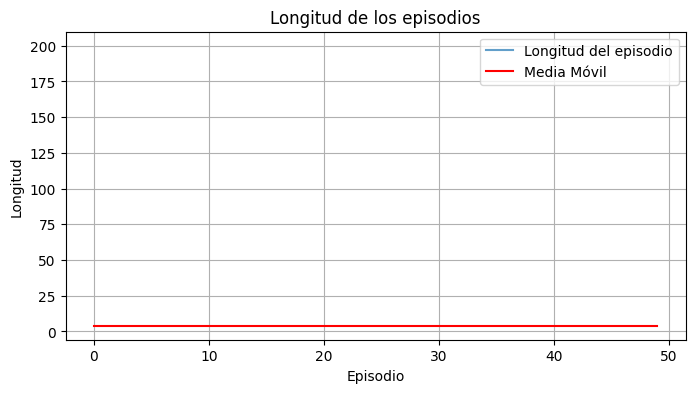

In [ ]:
plot_len_tendency(len_episode)

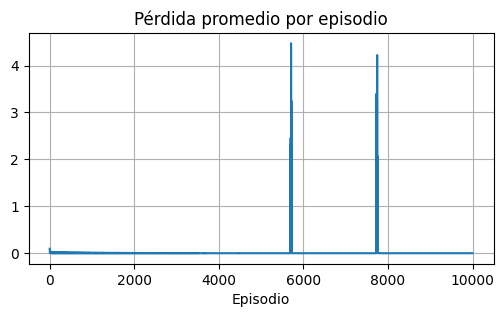

In [ ]:
plot_stats(episode_losses, 'Pérdida promedio por episodio')

## Evaluación

In [ ]:
# Ejecutar un episodio utilizando la política greedy y capturar los fotogramas.
frames = run_episode_greedy(agent)

# Crear el GIF a partir de los fotogramas capturados.
gif_path = frames_to_gif(frames)
print("GIF guardado en:", gif_path)

GIF guardado en: MountainCar_DeepQ.gif


In [ ]:
display_gif(gif_path)